In [20]:
import argparse
import torch
import torch.nn as nn
import numpy as np
import os
import pickle
import nltk
import pandas as pd
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
import csv
import torchvision.models as models
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
import timm
import pymeteor.pymeteor
from torchinfo import summary
from glob import glob
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import random
from torchvision.transforms import ToTensor
import torchvision
import textwrap
# Device configurationresul
tf = ToTensor()
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
topilimage = torchvision.transforms.ToPILImage()

In [2]:
params={'image_size':1024,
        'lr':2e-4,
        'beta1':0.5,
        'beta2':0.999,
        'batch_size':8,
        'epochs':10000,
        'data_path':'../../data/synth/type/',
        'train_csv':'BR_train.csv',
        'val_csv':'BR_test.csv',
        'vocab_path':'../../data/synth/type/BR_vocab.pkl',
        'embed_size':300,
        'hidden_size':256,
        'num_layers':4,}

In [ ]:
from os import path


class CustomDataset(Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self,data_list, data_path,image_size, csv, class_dataset, vocab, transform=None):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = data_path+'**/**/'
        self.df = pd.read_csv(data_path+csv)
        self.class_dataset=class_dataset
        self.vocab = vocab
        self.transform = transform
        self.image_size=image_size
        self.data_list=data_list
    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        df = self.df
        vocab = self.vocab
        img_id=df.loc[index]
        
        caption=img_id['caption']
        images = self.data_list[index]
        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        path = img_id['path']
        return images, target, path

    def __len__(self):
        return len(self.df)
    

class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.

    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.

    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions,path = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets,path, lengths

def idx2word(vocab, indices):
    sentence = []
    
    aa=indices.cpu().numpy()
    
    for index in aa:
        word = vocab.idx2word[index]
        sentence.append(word)
    return sentence
def word2sentence(words_list):
    sentence=''
    for word in words_list:
        if word.isalnum():
            sentence+=' '+word
        else:
            sentence+=word
    return sentence

with open(params['vocab_path'], 'rb') as f:
        vocab = pickle.load(f)
transform = transforms.Compose([ 
        transforms.RandomCrop(params['image_size']),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

df=pd.read_csv(params['data_path']+params['val_csv'])
test_list=torch.zeros(len(df),3,params['image_size'],params['image_size'])
for i in tqdm(range(len(df))):
    image=tf(Image.open(glob(params['data_path']+'**/**/'+df.loc[i]['path'])[0]).resize((params['image_size'],params['image_size'])))
    test_list[i]=image

test_dataset=CustomDataset(test_list,params['data_path'],params['image_size'],params['val_csv'],'val',vocab,transform=transform)

test_dataloader=DataLoader(test_dataset,batch_size=params['batch_size'],shuffle=False,collate_fn=collate_fn, drop_last=False)

In [ ]:

image_data = topilimage(test_dataset[0][0])

# 텍스트 내용
text_content =idx2word(vocab, test_dataset[0][1])

text_content =word2sentence([word for word in text_content if word not in ['<start>', '<end>', '<pad>']])
# 서브플롯 설정 (1행, 2열)
wrapped_text = "\n".join(textwrap.wrap(text_content, width=50))

# 서브플롯 설정 (1행, 2열)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# 첫 번째 서브플롯에 이미지 표시
ax1.imshow(image_data, cmap='gray')

ax1.set_title('Image')

# 두 번째 서브플롯에 줄바꿈된 텍스트 표시
ax2.text(0.5, 0.5, wrapped_text, va='center', ha='center', fontsize=12)
ax2.axis('off')  # 축 숨김
ax2.set_title('Text')
# 화면에 표시
plt.tight_layout()
plt.show()

In [29]:

class FeatureExtractor(nn.Module):
    """Feature extoractor block"""
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        cnn1= timm.create_model('efficientnetv2_s')
        self.feature_ex = nn.Sequential(*list(cnn1.children())[:-1])

    def forward(self, inputs):
        features = self.feature_ex(inputs)
        
        return features
    
class AttentionMILModel(nn.Module):
    def __init__(self, num_classes, image_feature_dim,feature_extractor_scale1: FeatureExtractor):
        super(AttentionMILModel, self).__init__()
        self.num_classes = num_classes
        self.image_feature_dim = image_feature_dim

        # Remove the classification head of the CNN model
        self.feature_extractor = feature_extractor_scale1
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(image_feature_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        # Classification layer
        self.classification_layer = nn.Linear(image_feature_dim, num_classes)

    def forward(self, inputs):
        batch_size, channels, height, width = inputs.size()
        
        # Flatten the inputs
        inputs = inputs.view(-1, channels, height, width)
        
        # Feature extraction using the pre-trained CNN
        features = self.feature_extractor(inputs)  # Shape: (batch_size , 2048, 1, 1)
        
        # Reshape features
        features = features.view(batch_size, -1)  # Shape: (batch_size, num_tiles, 2048)
        
        
        
        
        
        # Classification layer
        logits = self.classification_layer(features)  # Shape: (batch_size, num_classes)
        
        return logits  

class DecoderTransformer(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads, hidden_size, num_layers, max_seq_length=100):
        super(DecoderTransformer, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_length, embed_size))
        self.max_seq_length = max_seq_length
        self.vocab_size = vocab_size
        
        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=num_heads, dim_feedforward=hidden_size)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        self.linear = nn.Linear(embed_size, vocab_size)
        
    def forward(self, features, captions, teacher_forcing_ratio=1.0):
        """
        features: (batch_size, embed_size)
        captions: (batch_size, max_seq_length)
        """
        batch_size = features.size(0)
        max_seq_length = captions.size(1)
        
        # Output 저장을 위한 텐서 초기화
        outputs = torch.zeros(batch_size, max_seq_length, self.vocab_size).to(features.device)
        
        # features를 memory로 사용
        memory = features.unsqueeze(0)  # (1, batch_size, embed_size)
        
        # 첫 번째 입력 토큰은 <start> 토큰
        input_caption = captions[:, 0].unsqueeze(1)  # (batch_size, 1)
        
        for t in range(1, max_seq_length):
            # 임베딩 및 포지셔널 인코딩 적용
            input_embedded = self.embed(input_caption) + self.positional_encoding[:, :input_caption.size(1), :]
            input_embedded = input_embedded.permute(1, 0, 2)  # (seq_len, batch_size, embed_size)
            
            # 타겟 마스크 생성
            tgt_mask = self.generate_square_subsequent_mask(input_embedded.size(0)).to(features.device)
            
            # Transformer 디코더에 입력
            transformer_output = self.transformer_decoder(input_embedded, memory, tgt_mask=tgt_mask)
            transformer_output = transformer_output.permute(1, 0, 2)
            
            # 현재 시간 스텝의 출력 계산
            output = self.linear(transformer_output[:, -1, :])  # (batch_size, vocab_size)
            outputs[:, t, :] = output  # 출력 저장
            
            # 다음 입력 결정 (교사 강요 비율에 따라)
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            if use_teacher_forcing:
                # 실제 캡션의 다음 토큰 사용
                next_input = captions[:, t].unsqueeze(1)
            else:
                # 모델의 예측 사용
                _, predicted = output.max(1)
                next_input = predicted.unsqueeze(1)
            
            # 다음 입력을 input_caption에 추가
            input_caption = torch.cat([input_caption, next_input], dim=1)
        
        return outputs

    def generate_square_subsequent_mask(self, sz):
        """시퀀스의 순차적인 마스크 생성"""
        mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
        return mask

    def sample(self, features, max_seq_length=None):
        """Greedy Search 방식으로 시퀀스를 샘플링합니다."""
        if max_seq_length is None:
            max_seq_length = self.max_seq_length
        
        batch_size = features.size(0)
        sampled_ids = []
        
        # 첫 번째 토큰은 <start> 토큰
        input_caption = torch.ones(batch_size, 1).long().to(features.device)
        memory = features.unsqueeze(0)  # (1, batch_size, embed_size)
        
        for _ in range(max_seq_length):
            input_embedded = self.embed(input_caption) + self.positional_encoding[:, :input_caption.size(1), :]
            input_embedded = input_embedded.permute(1, 0, 2)
            tgt_mask = self.generate_square_subsequent_mask(input_embedded.size(0)).to(features.device)
            transformer_output = self.transformer_decoder(input_embedded, memory, tgt_mask=tgt_mask)
            transformer_output = transformer_output.permute(1, 0, 2)
            output = self.linear(transformer_output[:, -1, :])  # (batch_size, vocab_size)
            _, predicted = output.max(1)
            sampled_ids.append(predicted)
            input_caption = torch.cat([input_caption, predicted.unsqueeze(1)], dim=1)
        
        sampled_ids = torch.stack(sampled_ids, 1)
        return sampled_ids
def bleu_n(pred_words_list,label_words_list):

    bleu1 = sentence_bleu([label_words_list], pred_words_list, weights=(1, 0, 0, 0))


# BLEU@2 calculation
    bleu2 = sentence_bleu([label_words_list], pred_words_list, weights=(0, 1, 0, 0))


    bleu3=sentence_bleu([label_words_list], pred_words_list, weights=(0, 0, 1, 0))


    bleu4=sentence_bleu([label_words_list], pred_words_list, weights=(0, 0, 0, 1))
    return bleu1,bleu2,bleu3,bleu4

def rouge_scores(pred_sentence, label_sentence):
    # Initialize the ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    # Calculate the scores
    scores = scorer.score(label_sentence, pred_sentence)
    
    # Extract the precision, recall, and f1 scores for each ROUGE metric
    rouge1 = scores['rouge1']
    rouge2 = scores['rouge2']
    rougeL = scores['rougeL']
    
    # Return the ROUGE scores
    return rouge1, rouge2, rougeL

In [ ]:
Feature_Extractor=FeatureExtractor()
encoder = AttentionMILModel(params['embed_size'], 1280, Feature_Extractor).to(device)
decoder = DecoderTransformer(params['embed_size'], len(vocab), 15, params['hidden_size'], params['num_layers']).to(device)

criterion = nn.CrossEntropyLoss()
model_param = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.Adam(model_param, lr=params['lr'], betas=(params['beta1'], params['beta2']))
encoder.load_state_dict(torch.load('../../model/captioning/BR_encoder_check.pth',map_location=device))
decoder.load_state_dict(torch.load('../../model/captioning/BR_decoder_check.pth',map_location=device))


In [ ]:

total_labels = []
total_predictions = []
total_bleu=[]
total_Rogue=[]
test_df=pd.DataFrame(columns=['Path','Predicted','label','BLEU1','BLEU2','BLEU3','BLEU4','Rouge1','Rouge2','RougeL'])
with torch.no_grad():
    val_count = 0
    val_loss = 0.0 
    val_bleu_score = 0.0
    val = tqdm(test_dataloader)
    for images, captions,path, lengths in val:
        
        images = images.to(device)
        captions = captions.to(device)

        # Encoder를 통해 특징 추출
        features = encoder(images)
        # 캡션 생성 (교사 강요 없이)
        sampled_ids = decoder.sample(features)
        
        # BLEU 점수 계산
        for i in range(images.size(0)):
            val_count += 1
            predicted_caption = idx2word(vocab, sampled_ids[i])
            target_caption = idx2word(vocab, captions[i])
            
            # 특수 토큰 제거
            predicted_caption = [word for word in predicted_caption if word not in ['<start>', '<end>', '<pad>']]
            target_caption = [word for word in target_caption if word not in ['<start>', '<end>', '<pad>']]
            predicted_sentence=word2sentence(predicted_caption)
            target_sentence=word2sentence(target_caption)
            # BLEU-4 점수 계산
            bleu_score = sentence_bleu([target_caption], predicted_caption, weights=(1, 0, 0, 0))
            val_bleu_score += bleu_score
            bleu_11=bleu_n(predicted_caption,target_caption)
            total_bleu.append(bleu_11)
            # ROUGE 점수 계산
            rouge_score = rouge_scores(predicted_sentence, target_sentence)
            total_Rogue.append(rouge_score)
            # 예측과 정답 문장 저장
            total_labels.append(target_sentence)
            total_predictions.append(predicted_sentence)

            test_df.loc[len(test_df)]={'Path':path[i],'Predicted':predicted_sentence,'label':target_sentence,'BLEU1':bleu_11[0],'BLEU2':bleu_11[1],'BLEU3':bleu_11[2],'BLEU4':bleu_11[3],'Rouge1':rouge_score[0],'Rouge2':rouge_score[1],'RougeL':rouge_score[2]}
        val.set_description(f"test BLEU-1: {val_bleu_score/(val_count):.4f}")
test_df.to_csv('../../result/caption_result/BR_result.csv',index=False)

In [41]:
print(f'Bleu-1:{np.array(total_bleu)[:,0].mean():.4f}+-{np.array(total_bleu)[:,0].std():.4f} \nBleu-2:{np.array(total_bleu)[:,1].mean():.4f}+-{np.array(total_bleu)[:,1].std():.4f} \nBleu-3:{np.array(total_bleu)[:,2].mean():.4f}+-{np.array(total_bleu)[:,2].std():.4f} \nBleu-4:{np.array(total_bleu)[:,3].mean():.4f}+-{np.array(total_bleu)[:,3].std():.4f} \nRogue-1:{np.array(total_Rogue)[:,0].mean():.4f}+-{np.array(total_Rogue)[:,0].std():.4f} \nRogue-2:{np.array(total_Rogue)[:,1].mean():.4f}+-{np.array(total_Rogue)[:,1].std():.4f} \nRogue-L:{np.array(total_Rogue)[:,2].mean():.4f}+-{np.array(total_Rogue)[:,2].std():.4f}')

Bleu-1:0.9751+-0.1067 
Bleu-2:0.9666+-0.1432 
Bleu-3:0.9613+-0.1656 
Bleu-4:0.9570+-0.1830 
Rogue-1:0.9744+-0.1126 
Rogue-2:0.9652+-0.1518 
Rogue-L:0.9741+-0.1143


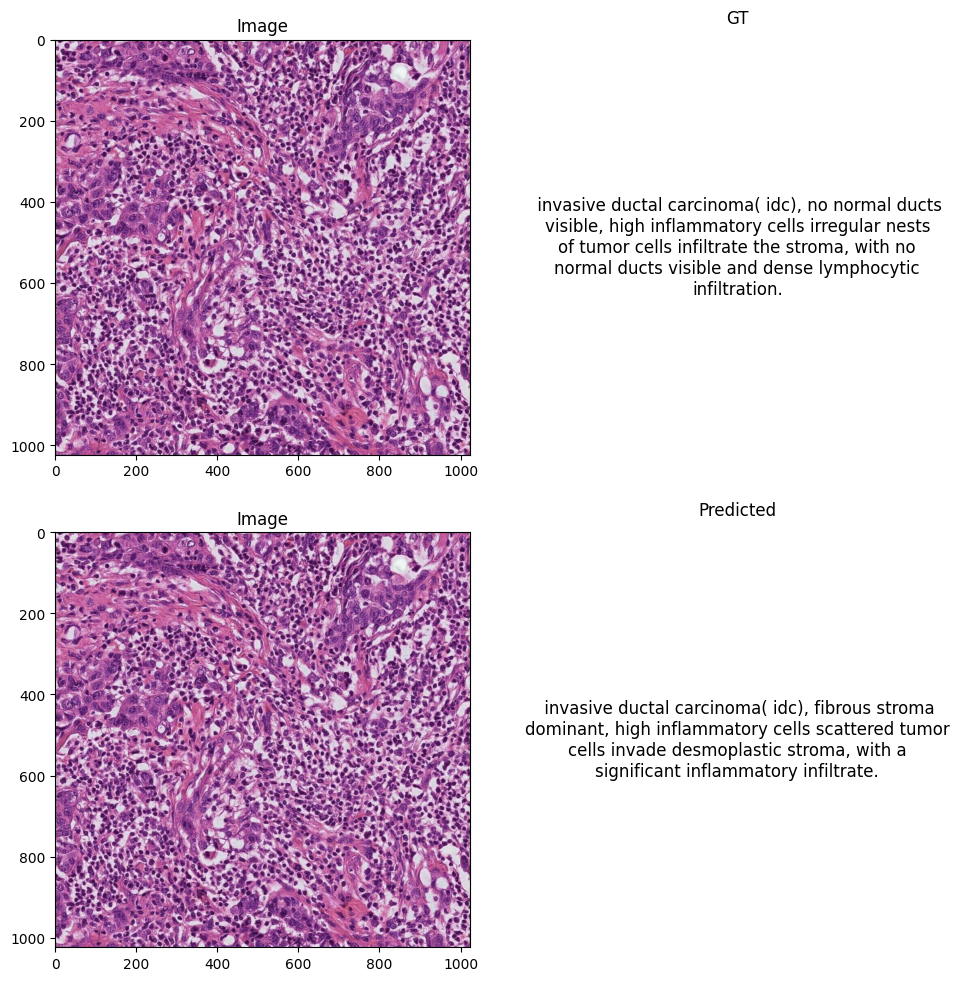

In [48]:
k=41
image_data = topilimage(test_dataset[k][0])

# 텍스트 내용

text_content =total_labels[k]
# 서브플롯 설정 (1행, 2열)
wrapped_text = "\n".join(textwrap.wrap(text_content, width=50))

# 서브플롯 설정 (1행, 2열)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# 첫 번째 서브플롯에 이미지 표시
axs[0,0].imshow(image_data)

axs[0,0].set_title('Image')

# 두 번째 서브플롯에 줄바꿈된 텍스트 표시
axs[0,1].text(0.5, 0.5, wrapped_text, va='center', ha='center', fontsize=12)
axs[0,1].axis('off')  # 축 숨김
axs[0,1].set_title('GT')

wrapped_text = "\n".join(textwrap.wrap(total_predictions[k], width=50))
# 첫 번째 서브플롯에 이미지 표시
axs[1,0].imshow(image_data)

axs[1,0].set_title('Image')

# 두 번째 서브플롯에 줄바꿈된 텍스트 표시
axs[1,1].text(0.5, 0.5, wrapped_text, va='center', ha='center', fontsize=12)
axs[1,1].axis('off')  # 축 숨김
axs[1,1].set_title('Predicted')
# 화면에 표시
plt.tight_layout()
plt.show()